In [8]:
def make_F(alphval):
    alpha = Constant(alphval)
    # Define the variational problem
    F = n*v_1*dx - n_n*v_1*dx 
    #Diffusion coefficient
    F += D*dot(grad(n), grad(v_1))*dt*dx
    # To account for cylindrical coordinates
    F += invr*D*dot(grad(n), Constant((1,)))*v_1*dt*dx
    F += dt*dot(grad(n_mid),v_s)*v_1*dx
    # To account for cylindrical coordinates
    F += invr*dt*n_mid*Constant(v_sval)*v_1*dx
    F -=dt*s_scal*n*v_2*dx-(rho-rho_n)*v_2*dx
    F += beta*v_1*rho*(n)*dt*dx
    F -= alpha*(n)*v_1*dt*dx

    #Solve concentration

    F += C*v_0*dx - C_n*v_0*dx 
    F += Vmax*(rho)*(C/(Kp+C))*v_0*dt*dx
    #Diffusion coefficient
    F += D2*dot(grad(C), grad(v_0))*dt*dx
    # To account for cylindrical coordinates
    F += invr*D2*dot(grad(C), Constant((1,)))*v_0*dt*dx
    return(F)

In [6]:
import dolfin
print(dolfin.__file__)  # Shows the file path
print(dolfin.__version__)  # Shows the version

/usr/lib/petsc/lib/python3/dist-packages/dolfin/__init__.py
2019.2.0.dev0


/tmp/ipykernel_559/1970181911.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")
/tmp/ipykernel_559/1970181911.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")


Text(0, 0.5, '$\\rho (mm.mm^{-2})$')

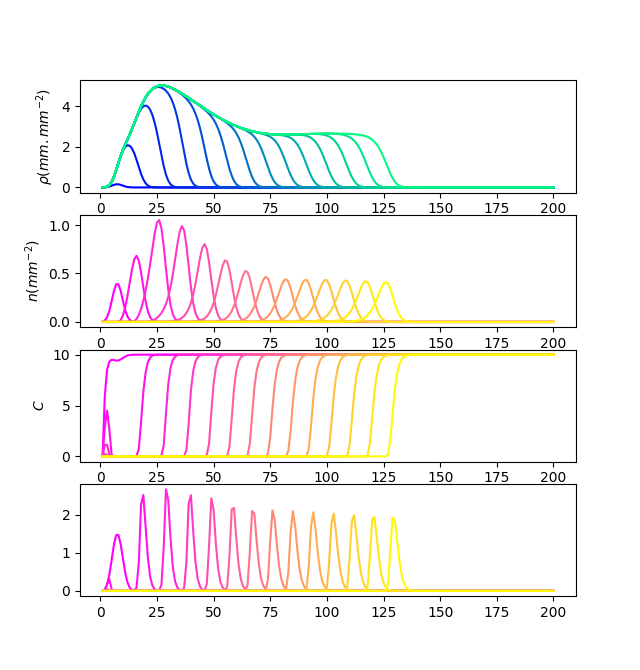

In [18]:
%matplotlib widget
from dolfin import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
width = 3.2
height = 2
plt.close("all")
set_log_active(False)

cmap2 = mpl.cm.get_cmap("spring")
cmap = mpl.cm.get_cmap("winter")

# Define the problem
Length = 200.0
nx = 200
nT = 200
mesh = IntervalMesh(nx, 1, Length)
P1 = FiniteElement('P', interval, 1)
element = MixedElement([P1, P1,P1])
V = FunctionSpace(mesh, element)

# Define the parameters
T = 400
dt = T/nT
alphval = 0.039
cval = 0.6
# Define the initial condition
C0 = 10
u0 = Expression(('0.4*exp(-0.1*pow(abs(x[0]-7),2))',f'(1-exp(-(x[0]-1)))*{C0}',0), degree=1)
rexp = Expression(('1/x[0]',0,0),degree=1)
r = interpolate(rexp, V)
invr, _, _ = split(r)

u_n = interpolate(u0, V)
u = Function (V)
n,C, rho = split(u)
n_n,C_n, rho_n= split(u_n)
v_1, v_0,v_2 = TestFunctions(V)
sp = Constant((0.3,))

Fmax = 2 #ug.cm**-2.h-1
Vmax=Fmax
Kp = 1
Pprice_ideal = 20

s_scal = Constant(0.2)
beta = Constant(0.022)
alpha = Constant(alphval)
D = Constant(0.02)
D2 = Constant(0.02)

n_mid = 0.5*(n_n + n)
v_sval = 0.230
v_s = Constant((v_sval,))

# Apply the boundary conditions
u_L = (Constant(0.0),Constant(0.0),Constant(0.0))
u_R = (Constant(0.0),Constant(C0),Constant(0.0))
bc_L = DirichletBC(V, u_L, 'near(x[0], 1.0)')
bc_R = DirichletBC(V, u_R, f'near(x[0], {Length})')
bcs = [bc_L, bc_R]

# bc = PeriodicBC(V, Boundary())# Solve the problem
t = 0.0
V2 = FunctionSpace(mesh, 'P', 1)
X = np.linspace(1,Length,nx)
poss = []
Pprices = []
fix,axs = plt.subplots(4,1,figsize=(2*width,height*3.35))
i=0
for t in np.linspace(0,T,nT):
    F = make_F(alphval)
    solve(F==0, u,bcs)
    u_n.assign(u)
    _n,_C_p, _rho= u.split()
    n_field = interpolate(_n, V2)
    rho_field = interpolate(_rho, V2)
    C_field = interpolate(_C_p, V2)
    if i%15==0:

        axs[1].plot(X,[n_field(x) for x in X],color=cmap2(t/T))
        
        # axs[0].set_yscale('log')
        axs[0].plot(X,[rho_field(x) for x in X],color=cmap(t/T))
        axs[2].plot(X,[C_field(x) for x in X],color=cmap2(t/T))
        axs[3].plot(X,[C_field(x)*rho_field(x) for x in X],color=cmap2(t/T))
    Pprice = np.sum([Vmax*C_field(x)*rho_field(x)*np.pi*x**2 for x in X])/np.sum([n_field(x)*np.pi*x**2*v_sval for x in X])
    alphval = alphval - dt*0.00005*(Pprice_ideal-Pprice)
    Pprices.append(Pprice)
    poss.append(np.argmax([n_field(x) for x in X]))
    i+=1
    # break
axs[0].set_xlabel('',size=14)
axs[1].set_ylabel('$n (mm^{-2})$')

axs[2].set_xlabel('position ($mm$)')
axs[2].set_ylabel('$C$')
axs[1].set_xlabel('',size=14)
axs[0].set_ylabel(r'$\rho (mm.mm^{-2})$')

In [39]:
satrho = nump.median([rho_field(x) for x in X if rho_field(x)>0.1])
satrho

2.3600211694166786

In [19]:
satrho = np.median([rho_field(x) for x in X if rho_field(x)>0.1])
satrho

2.656260054964261

/tmp/ipykernel_44/3129500986.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("winter")
/tmp/ipykernel_44/3129500986.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = mpl.cm.get_cmap("spring")


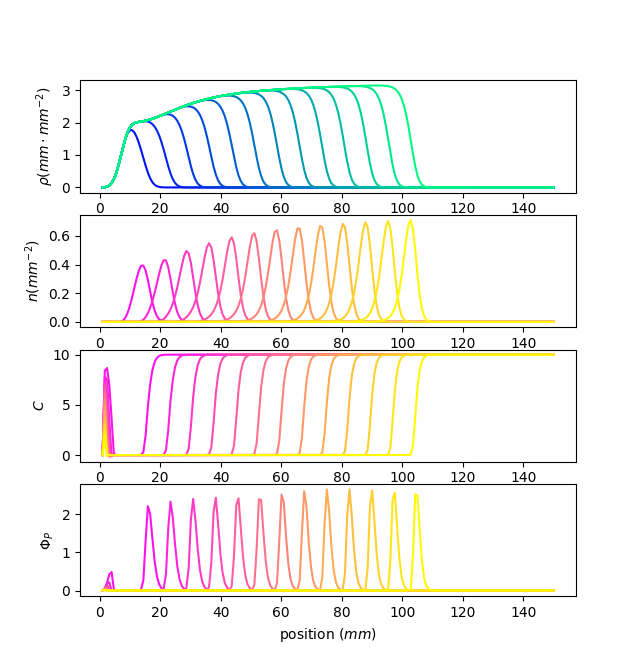

In [76]:
%matplotlib widget
from dolfin import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
plt.close("all")
set_log_active(False)
class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=150.0, nx=200, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3.2, height=2,speed = 0.230):
        self.Length = Length
        self.nx = nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = 5e-5
        self._setup_simulation()

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('0.4*exp(-0.1*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-3*(x[0]-1)))*{self.C0}', '0'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.039
        self.cval = 0.6
        self.s_scal = Constant(self.speed)
        self.beta = Constant(0.022)
        self.alpha = Constant(self.alphval)
        self.D = Constant(0.002)
        self.D2 = Constant(0.0002)
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed
        self.v_s = Constant((self.v_sval,))
        self.Vmax = self.Fmax
        self.Kp = 1
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval):
        # Define the variational problem F
        alpha = Constant(alphval)
        # Define the variational problem
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # Diffusion coefficient
        F += self.D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        F -= self.dt*self.s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx

        # Solve concentration
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx 
        F += self.Vmax*(self.rho)*(self.C/(self.Kp+self.C))*self.v_0*self.dt*dx
        # Diffusion coefficient
        F += self.D2*dot(grad(self.C), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []

        # Initialize matplotlib plots if needed
        if plot:
            plt.close("all")
            fig, axs = plt.subplots(4, 1, figsize=(self.width*2, self.height * 3.35))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        for t in np.linspace(0, self.T, self.nT):
            i+=1
            F = self._make_F(self.alphval)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.sum([n_field(x)*np.pi*x**2*self.v_sval*1.16 for x in X])
            Pacquisition = np.sum([self.Vmax*C_field(x)*rho_field(x)*np.pi*x**2 for x in X])
            Pprice = Ccost/Pacquisition
            self.alphval = self.alphval - self.dt*self.adaptation_rate*(self.Pprice_ideal-Pprice)
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # Plotting logic
            if plot and i % 15 == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, C_xt[-1], color=cmap2(t / self.T))
                axs[3].plot(X, [C_xt[-1][i] * rho_xt[-1][i] for i in range(len(X))], color=cmap2(t / self.T))

        # Finalize plot settings if plotting
        if plot:
            axs[0].set_ylabel(r'$\rho (mm \cdot mm^{-2})$')
            axs[1].set_ylabel('$n (mm^{-2})$')
            axs[2].set_ylabel('$C$')
            axs[3].set_ylabel('$\Phi_P$')
            
            axs[3].set_xlabel('position ($mm$)')
            plt.show()

        return C_xt, rho_xt, n_xt,P_prices
        

# Example usage:
sim = Simulation(speed = 0.20,C0=10,T = 400,nT=200,Pprice_ideal = 1/20)
C_xt, rho_xt, n_xt,P_prices = sim.integrate(plot=True)

0.1290573529411765


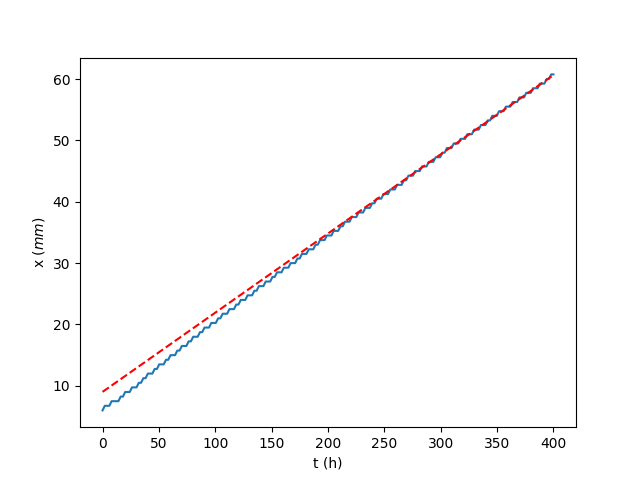

In [74]:
poss = np.argmax(n_xt,axis=1)
x = np.linspace(0,sim.T,sim.nT)
y = np.array(poss)*sim.Length/sim.nx
fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, fit_line, 'r--')
ax.set_xlabel('t (h)')
ax.set_ylabel('x ($mm$)')
print(fit_coeffs[0])

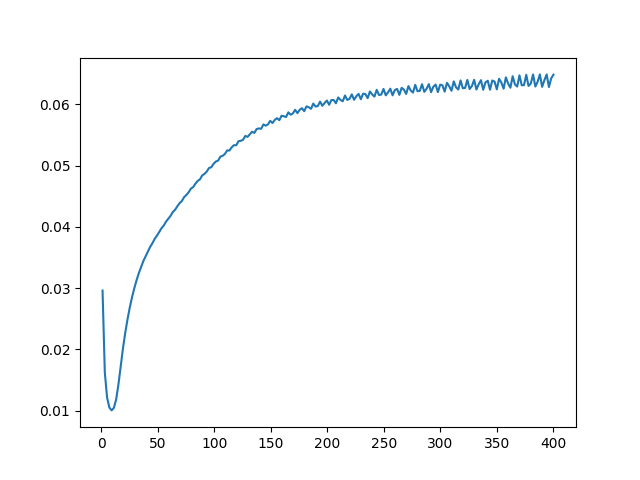

In [75]:
fig,ax = plt.subplots()
ax.plot(np.linspace(1, sim.T, sim.nT),P_prices)

In [83]:
satrho = np.median([rho for rho in rho_xt[-1] if rho>0.1])
satrho

3.130733022650189

In [81]:
satrho = np.median([rho for rho in rho_xt[-1] if rho>0.1])
satrho

2.6078046088590305

In [65]:
def get_rhosat(speed,C0=10,Pprice_ideal = 20):
    sim = Simulation(speed = speed,C0=C0,T = 400,nT=200,Pprice_ideal = Pprice_ideal)
    C_xt, rho_xt, n_xt,P_prices = sim.integrate(plot=False)
    rho_sat = np.median([rho for rho in rho_xt[-1] if rho>0.1])
    poss = np.argmax(n_xt,axis=1)
    x = np.linspace(0,sim.T,sim.nT)
    y = np.array(poss)*sim.Length/sim.nx
    fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
    return(rho_sat,fit_coeffs[0])

In [66]:
speeds = np.linspace(0.10,0.20,4)
rho_sats_speeds = [get_rhosat(speed,C0=1,Pprice_ideal=0.4) for speed in speeds]
    

In [67]:
speeds_observed = [speed for _,speed in rho_sats_speeds]
rho_sats = [rho for rho,_ in rho_sats_speeds]

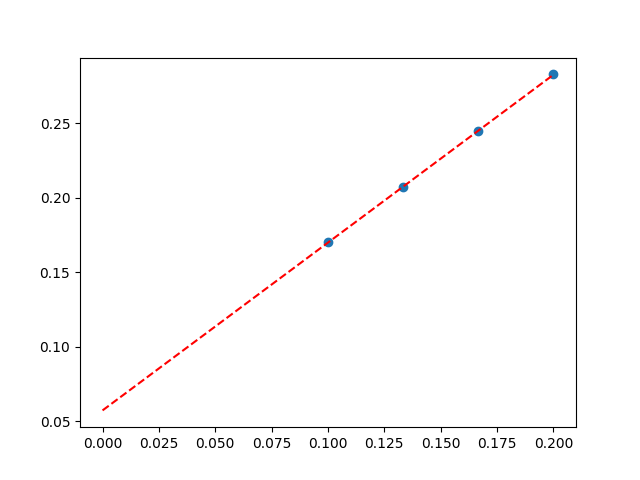

In [68]:
fig,ax = plt.subplots()
ax.scatter(speeds,speeds_observed)
fit_coeffs = np.polyfit(speeds, speeds_observed, 1)
x = [0,0.20]
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
ax.plot(x, fit_line, 'r--')
# ax.set_xscale("log")
# ax.set_yscale("log")

In [69]:
fit_coeffs[0]

1.1252339135654255

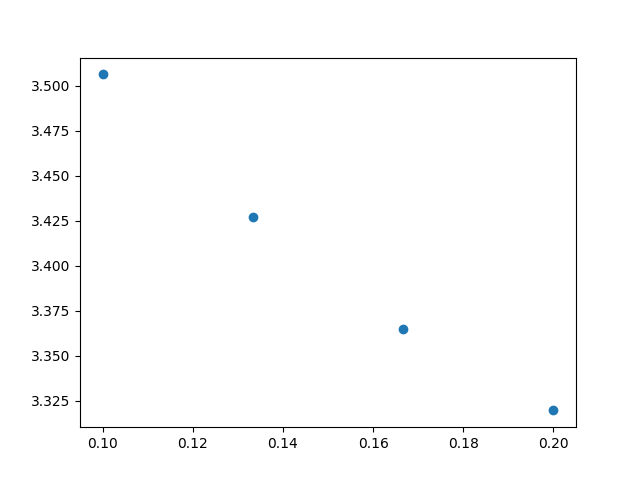

In [70]:
fig,ax = plt.subplots()
ax.scatter(speeds,rho_sats)